In [4]:
# Install required packages
# Run this cell first if packages are not already installed

%pip install numpy pandas nltk scikit-learn imbalanced-learn tensorflow keras matplotlib seaborn

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.12.19-py2.py3-none-any.whl.metadata (1.0 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.33.4-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
  Using cached grpcio-1.76.0-cp311-cp311-macosx_11_0_universal2.whl.metadata (3.7 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached rich-14.2.0-py3-none-any.whl.metadata (18 kB)
  Using cached markdown_it_py-4.0.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 MB 890.8 kB/s  0:04:180:00:0100:07
Using cached grpcio-1.76.0-cp311-cp311-macosx_11_0_universal2.whl (11.8 MB)
   ━━━━━━━━━━

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import ADASYN
from collections import Counter
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, InputLayer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv(r'/Users/sk/Library/Mobile Documents/com~apple~CloudDocs/3. Techno (Professional)/21. Prj2_Transformer based Comment analyzer Chrome Plugin/ Prj2_CodeFile/data/dataset.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (37249, 3)


,Unnamed: 0,clean_comment,category
0,0,family mormon have never tried explain them t...,1
1,1,buddhism has very much lot compatible with chr...,1
2,2,seriously don say thing first all they won get...,-1
3,3,what you have learned yours and only yours wha...,0
4,4,for your own benefit you may want read living ...,1


In [3]:
# Data cleaning
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df = df[~(df['clean_comment'].str.strip() == '')]
print(f"Dataset shape after cleaning: {df.shape}")

Dataset shape after cleaning: (37028, 3)


In [4]:
# Download NLTK data (if needed)
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
except:
    pass

# Define preprocessing function
def preprocess_comment(comment):
    # Convert to lowercase
    comment = comment.lower()
    # Remove trailing and leading whitespaces
    comment = comment.strip()
    # Remove newline characters
    comment = re.sub(r'\n', '', comment)
    # Remove non-alphanumeric characters, except punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)
    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])
    return comment

# Apply preprocessing
df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)
print("Preprocessing completed!")

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


Preprocessing completed!


In [5]:
# Vectorize the comments using Bag of Words (CountVectorizer)
vectorizer = CountVectorizer(max_features=5000)
x = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category'].values

print(f"Original data shape: {x.shape}")
print("Original class distribution:")
print(Counter(y))

Original data shape: (37028, 5000)
Original class distribution:
Counter({np.int64(1): 15830, np.int64(0): 12921, np.int64(-1): 8277})


In [6]:
# Apply ADASYN to handle class imbalance
print("\nApplying ADASYN for class balancing...")
adasyn = ADASYN(random_state=42, n_neighbors=5)
x_resampled, y_resampled = adasyn.fit_resample(x, y)

print(f"\nResampled data shape: {x_resampled.shape}")
print("Resampled class distribution:")
print(Counter(y_resampled))

# Update x and y with resampled data
x = x_resampled
y = y_resampled
print("\nData balanced successfully! Ready for model training.")


Applying ADASYN for class balancing...

Resampled data shape: (48845, 5000)
Resampled class distribution:
Counter({np.int64(0): 17744, np.int64(1): 15830, np.int64(-1): 15271})

Data balanced successfully! Ready for model training.


In [7]:
# Split dataset into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")
print(f"\nTrain class distribution:")
print(Counter(y_train))
print(f"\nTest class distribution:")
print(Counter(y_test))

Train set shape: (39076, 5000)
Test set shape: (9769, 5000)

Train class distribution:
Counter({np.int64(0): 14195, np.int64(1): 12664, np.int64(-1): 12217})

Test class distribution:
Counter({np.int64(0): 3549, np.int64(1): 3166, np.int64(-1): 3054})


In [8]:
# ============================================
# RANDOM FOREST CLASSIFIER
# ============================================
print("="*60)
print("Training Random Forest Classifier")
print("="*60)

# Train Random Forest
n_estimators = 150
max_depth = 15
rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
rf_model.fit(x_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(x_test)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"\nRandom Forest Accuracy: {rf_accuracy:.4f}")

# Classification report
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Training Random Forest Classifier

Random Forest Accuracy: 0.6102

Random Forest Classification Report:
              precision    recall  f1-score   support

          -1       0.87      0.16      0.27      3054
           0       0.53      0.97      0.69      3549
           1       0.73      0.64      0.68      3166

    accuracy                           0.61      9769
   macro avg       0.71      0.59      0.55      9769
weighted avg       0.70      0.61      0.56      9769



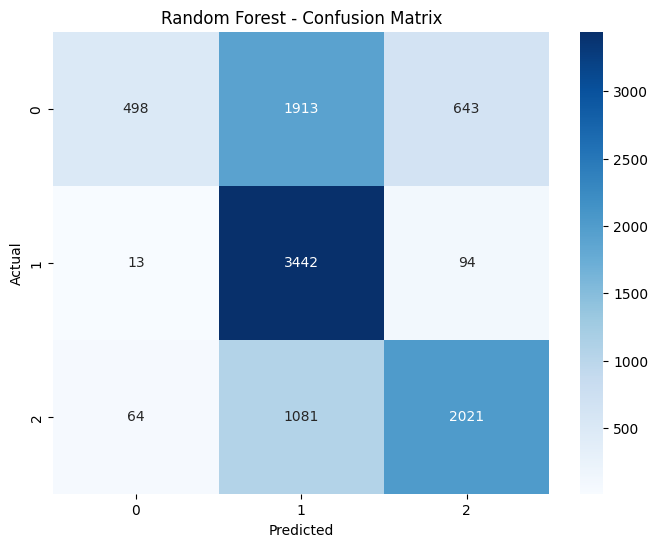

In [9]:
# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest - Confusion Matrix")
plt.show()

In [10]:
# ============================================
# DEEP NEURAL NETWORK
# ============================================
print("="*60)
print("Training Deep Neural Network")
print("="*60)

# Map labels to 0, 1, 2 for neural network (if needed)
y_train = y_train + 1
y_test = y_test + 1

Training Deep Neural Network


In [11]:
# Build Deep Neural Network model
dnn_model = Sequential()
dnn_model.add(InputLayer(shape=(5000,)))
dnn_model.add(Dense(512, activation='relu'))
dnn_model.add(Dense(256, activation='relu'))
dnn_model.add(Dense(128, activation='relu'))
dnn_model.add(Dense(64, activation='relu'))
dnn_model.add(Dense(32, activation='relu'))
dnn_model.add(Dense(3, activation='softmax'))

# Compile the model
dnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
dnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,735,171 (10.43 MB)

 Trainable params: 2,735,171 (10.43 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the Deep Neural Network
dnn_model.fit(x_train, y_train, epochs = 10, batch_size = 1024)

Epoch 1/10


In [ ]:
# Make predictions with DNN
y_pred_proba_dnn = dnn_model.predict(x_test)
y_pred_dnn = np.argmax(y_pred_proba_dnn, axis=1)

# Map predictions back to original labels (0 -> -1, 1 -> 0, 2 -> 1)
reverse_mapping = {0: -1, 1: 0, 2: 1}
y_pred_dnn_mapped = np.array([reverse_mapping[pred] for pred in y_pred_dnn])

# Calculate accuracy
dnn_accuracy = accuracy_score(y_test, y_pred_dnn_mapped)
print(f"\nDeep Neural Network Accuracy: {dnn_accuracy:.4f}")

# Classification report
print("\nDeep Neural Network Classification Report:")
print(classification_report(y_test, y_pred_dnn_mapped))

In [ ]:
# Confusion Matrix for Deep Neural Network
conf_matrix_dnn = confusion_matrix(y_test, y_pred_dnn_mapped)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dnn, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Deep Neural Network - Confusion Matrix")
plt.show()

In [ ]:
# ============================================
# MODEL COMPARISON SUMMARY
# ============================================
print("="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(f"\nRandom Forest Classifier:")
print(f"  Accuracy: {rf_accuracy:.4f}")

print(f"\nDeep Neural Network:")
print(f"  Accuracy: {dnn_accuracy:.4f}")

print("\n" + "="*60)
print("Both models trained successfully with ADASYN-balanced data!")
print("="*60)

MODEL COMPARISON SUMMARY

Random Forest Classifier:


NameError: name 'rf_accuracy' is not defined